<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/split_ICI_test_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

## 0-1 Install Dependences

In [56]:
#to-do, try to improve accuracy by playing around with the ici data. 
# try to figure out one what sentence BERT guessed correctly. Because there is still some room for improvement there. 
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 0-2 Parameters

In [57]:
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 6:
    model_classifier = "owen198/weibo-wmmbert-6"
else:
    model_classifier = "owen198/weibo-wmmbert-2"


# 1 Load Dataset

In [58]:
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx

File ‘df_sample.xlsx’ already there; not retrieving.



In [59]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['angry']=0 #neg
    ici_map_dict['anger']=0 #neg
    ici_map_dict['positive']=1 #pos
    ici_map_dict['posiitive']=1 #pos
    ici_map_dict['happy']=1 #pos
    ici_map_dict['neutral']=3 #ignore
    ici_map_dict['neural']=3 #ignore
    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['suprise']=3 #ignore
    ici_map_dict['sad']=0 #neg
    ici_map_dict['negative']=0 #neg
    ici_map_dict['fear']=0 #neg

len(ici_map_dict)

12

# 2 Clean and split data

In [60]:
import pandas as pd

In [61]:
testing_pd= pd.read_excel('/content/df_sample.xlsx')

In [62]:
testing_pd = pd.read_excel('/content/df_sample.xlsx')

testing_pd = testing_pd[['text', 'cya_check_3']]
testing_pd = testing_pd.rename(columns={'cya_check_3':'label'})
testing_pd = testing_pd[(testing_pd['label'] == 'negative') | (testing_pd['label'] == 'positive')]


# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(123, 2)

In [63]:
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
# title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
#span_pattern='<span.*?>(.+?)</span>'





#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

In [64]:
#split text on '。'
#step 1: split the raw_df into a df that preserves the original posts' labels
#step 2: create split raw_df again into another df that preserves the original posts' Post_number (for our own reference)
#step 3: insert sentiment labels from first df into the second df so we have a split df that shows 
#        both the posts original Post_number and labels
split_for_label_df = pd.DataFrame(testing_pd.text.str.split('。').tolist(), index=testing_pd.label).stack()
split_for_label_df

label   
0      0    对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...
       1    文化大学教授郭正亮认为，这份民调问题很多！要帮陈时中“冲喜”！陈时中的仇恨值超过大家的想像！...
       0                                 #台湾# 深圳卫视正午30分的微博视频 
       0    针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...
       1                                                     
                                  ...                        
       3                                                     
       0    资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...
       1    对此，前立委郭正亮在节目中指出，周玉蔻节目被移回152台民视台湾台播出，影响力就被削弱许多，...
       2                                                     
       0                                   额？？？这是蒋万安的竞选团队？？？ 
Length: 362, dtype: object

In [65]:
split_for_label_df = split_for_label_df.reset_index([0, 'label',])

In [66]:
#set column back to sentiment and text
split_for_label_df.columns = ['label', 'text']

In [67]:
#delete empty rows
split_for_label_df = split_for_label_df[split_for_label_df['text'].str.len()>=1]
split_for_label_df = split_for_label_df.reset_index()

In [68]:
split_for_label_df

,index,label,text
0,0,0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...
1,1,0,文化大学教授郭正亮认为，这份民调问题很多！要帮陈时中“冲喜”！陈时中的仇恨值超过大家的想像！...
2,2,0,#台湾# 深圳卫视正午30分的微博视频
3,3,0,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...
4,4,0,
...,...,...,...
326,356,0,蔣萬安雖然回擊了一下，但完全應該集中火力猛攻周，持續回擊和反攻，以此贏回藍營搖擺選民的信心
327,357,0,
328,358,0,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...
329,359,0,对此，前立委郭正亮在节目中指出，周玉蔻节目被移回152台民视台湾台播出，影响力就被削弱许多，...


In [69]:
import numpy as np
testing_pd['Post_number'] = np.arange(len(testing_pd))

In [70]:
#step 2: create split raw_df again into another df that preserves the original posts' Post_number (for our own reference)
challenge_split_df = pd.DataFrame(testing_pd.text.str.split('。').tolist(), index=testing_pd.Post_number).stack()
challenge_split_df

Post_number   
0            0    对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...
             1    文化大学教授郭正亮认为，这份民调问题很多！要帮陈时中“冲喜”！陈时中的仇恨值超过大家的想像！...
1            0                                 #台湾# 深圳卫视正午30分的微博视频 
2            0    针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...
             1                                                     
                                        ...                        
116          3                                                     
117          0    资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...
             1    对此，前立委郭正亮在节目中指出，周玉蔻节目被移回152台民视台湾台播出，影响力就被削弱许多，...
             2                                                     
118          0                                   额？？？这是蒋万安的竞选团队？？？ 
Length: 362, dtype: object

In [71]:
challenge_split_df = challenge_split_df.reset_index([0, 'Post_number',])

In [72]:
#set column back to Post_number and text
challenge_split_df.columns = ['Post_number', 'text']

In [73]:
#delete empty rows
challenge_split_df = challenge_split_df[challenge_split_df['text'].str.len()>=1]
challenge_split_df = challenge_split_df.reset_index()

In [74]:
challenge_split_df

,index,Post_number,text
0,0,0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...
1,1,0,文化大学教授郭正亮认为，这份民调问题很多！要帮陈时中“冲喜”！陈时中的仇恨值超过大家的想像！...
2,2,1,#台湾# 深圳卫视正午30分的微博视频
3,3,2,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...
4,4,2,
...,...,...,...
326,356,116,蔣萬安雖然回擊了一下，但完全應該集中火力猛攻周，持續回擊和反攻，以此贏回藍營搖擺選民的信心
327,357,116,
328,358,117,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...
329,359,117,对此，前立委郭正亮在节目中指出，周玉蔻节目被移回152台民视台湾台播出，影响力就被削弱许多，...


In [75]:
#step 3: take sentiment labels from the split_for_label_df and insert them into challenge_split_df for final dataframe that we can use for testing
extracted_col2 = split_for_label_df["label"]
challenge_split_df.insert(1, "label", extracted_col2)

In [76]:
#mission accomplished, I verified the output with the original excel sheet and it all checks out.
testing_pd = challenge_split_df

In [77]:
testing_pd

,index,label,Post_number,text
0,0,0,0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...
1,1,0,0,文化大学教授郭正亮认为，这份民调问题很多！要帮陈时中“冲喜”！陈时中的仇恨值超过大家的想像！...
2,2,0,1,#台湾# 深圳卫视正午30分的微博视频
3,3,0,2,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...
4,4,0,2,
...,...,...,...,...
326,356,0,116,蔣萬安雖然回擊了一下，但完全應該集中火力猛攻周，持續回擊和反攻，以此贏回藍營搖擺選民的信心
327,357,0,116,
328,358,0,117,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...
329,359,0,117,对此，前立委郭正亮在节目中指出，周玉蔻节目被移回152台民视台湾台播出，影响力就被削弱许多，...


# main code continued

In [78]:
#testing_pd = pd.read_excel('/content/balanced_test_numbered_clean.xlsx')
#this code still removes the Post_number column. If we need that one for future research we will have to adjust some part of this code to preserve that column. 

testing_pd = testing_pd[['Post_number','text', 'label']]
#testing_pd = testing_pd.rename(columns={'sentiment':'label'})

# align labels
# testing_pd['label'].unique()
#testing_pd['label'] = testing_pd['label'].str.lower()
#testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
#testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
#testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd

,Post_number,text,label
0,0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
1,0,文化大学教授郭正亮认为，这份民调问题很多！要帮陈时中“冲喜”！陈时中的仇恨值超过大家的想像！...,0
2,1,#台湾# 深圳卫视正午30分的微博视频,0
3,2,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0
4,2,,0
...,...,...,...
326,116,蔣萬安雖然回擊了一下，但完全應該集中火力猛攻周，持續回擊和反攻，以此贏回藍營搖擺選民的信心,0
327,116,,0
328,117,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0
329,117,对此，前立委郭正亮在节目中指出，周玉蔻节目被移回152台民视台湾台播出，影响力就被削弱许多，...,0


In [80]:
num_label = len(testing_pd['label'].unique())
num_label

2

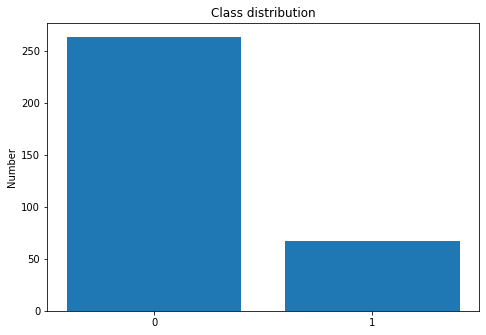

In [81]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(testing_pd['label'].unique(),
       testing_pd.groupby(['label']).count()['text'].tolist())

ax.set_xticks(testing_pd.groupby(['label']).count().index.values)

ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [82]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [83]:
from transformers import AutoTokenizer

In [84]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-bert-wwm/snapshots/ab0aa81da273504efc8540aa4d0bbaa3016a1bb5/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-bert-wwm",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

In [85]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [86]:
full_test_dataset = tokenized_datasets["test"]

In [87]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--owen198--weibo-wmmbert-2/snapshots/1c8b069ca4f42474887b1be5ddb45d0b190b785d/config.json
Model config BertConfig {
  "_name_or_path": "owen198/weibo-wmmbert-2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "f

In [88]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 3 Evaluation and results 

In [89]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [90]:
import numpy as np

trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Post_number, text. If Post_number, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 331
  Batch size = 8


{'eval_loss': 0.8624988794326782,
 'eval_accuracy': 0.7764350453172205,
 'eval_runtime': 11.4394,
 'eval_samples_per_second': 28.935,
 'eval_steps_per_second': 3.672}

In [91]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Post_number, text. If Post_number, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 331
  Batch size = 8


In [ ]:
pred

In [93]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [94]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [95]:
#see in what sentence number BERT guessed incorrectly. 
testing_pd

,Post_number,text,label,pred
0,0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0,0
1,0,文化大学教授郭正亮认为，这份民调问题很多！要帮陈时中“冲喜”！陈时中的仇恨值超过大家的想像！...,0,0
2,1,#台湾# 深圳卫视正午30分的微博视频,0,1
3,2,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0,0
4,2,,0,0
...,...,...,...,...
326,116,蔣萬安雖然回擊了一下，但完全應該集中火力猛攻周，持續回擊和反攻，以此贏回藍營搖擺選民的信心,0,1
327,116,,0,0
328,117,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0,0
329,117,对此，前立委郭正亮在节目中指出，周玉蔻节目被移回152台民视台湾台播出，影响力就被削弱许多，...,0,0


# 4 More review options (under construction)

In [96]:
#review_pd = testing_pd[['Post_number', 'label', 'pred']]       

In [ ]:
#review_pd

In [98]:
#calcreview=review_pd.eval("d= pred - label")

In [99]:
#calcreview

,Post_number,label,pred,d
0,0,0,0,0
1,0,0,0,0
2,1,0,1,1
3,2,0,0,0
4,2,0,0,0
...,...,...,...,...
326,116,0,1,1
327,116,0,0,0
328,117,0,0,0
329,117,0,0,0


In [100]:
#calcreview1 = calcreview[calcreview.d != 0]

In [101]:
#calcreview1

,Post_number,label,pred,d
2,1,0,1,1
9,4,0,1,1
17,5,1,0,-1
19,5,1,0,-1
26,7,0,1,1
...,...,...,...,...
306,108,0,1,1
308,110,0,1,1
314,112,0,1,1
319,113,0,1,1


In [102]:
#review_pd.diff(axis=1)

,Post_number,label,pred
0,NaN,0,0
1,NaN,0,0
2,NaN,-1,1
3,NaN,-2,0
4,NaN,-2,0
...,...,...,...
326,NaN,-116,1
327,NaN,-116,0
328,NaN,-117,0
329,NaN,-117,0


In [103]:
#testing_pd = testing_pd.groupby('Post_number').sum()
#print(testing_pd)

             label  pred
Post_number             
0                0     0
1                0     1
2                0     0
3                0     0
4                0     1
...            ...   ...
114              0     0
115              0     0
116              0     1
117              0     0
118              0     0

[119 rows x 2 columns]


In [104]:
#testing_pd

,label,pred
Post_number,,
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1
...,...,...
114,0,0
115,0,0
116,0,1
